Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

### Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.

In [3]:
# I want to look at my dataset
df.head(3)

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
df = df.drop(['display_address', 'description', 'latitude', 'longitude', 'street_address', 'elevator', 'dishwasher', 'pre-war', 'dining_room', 'new_construction'], axis=1)

In [5]:
df.head(3)

,bathrooms,bedrooms,created,price,interest_level,cats_allowed,hardwood_floors,dogs_allowed,doorman,no_fee,laundry_in_building,fitness_center,laundry_in_unit,roof_deck,outdoor_space,high_speed_internet,balcony,swimming_pool,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,3000,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,5465,low,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,2850,high,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
# Look at the created column
df['created']

0        2016-06-24 07:54:24
1        2016-06-12 12:19:27
2        2016-04-17 03:26:41
3        2016-04-18 02:22:02
4        2016-04-28 01:32:41
                ...         
49347    2016-06-02 05:41:05
49348    2016-04-04 18:22:34
49349    2016-04-16 02:13:40
49350    2016-04-08 02:13:33
49351    2016-04-12 02:48:07
Name: created, Length: 48817, dtype: object

In [0]:
df['created'] = pd.to_datetime(df['created'])

In [8]:
df['created']

0       2016-06-24 07:54:24
1       2016-06-12 12:19:27
2       2016-04-17 03:26:41
3       2016-04-18 02:22:02
4       2016-04-28 01:32:41
                ...        
49347   2016-06-02 05:41:05
49348   2016-04-04 18:22:34
49349   2016-04-16 02:13:40
49350   2016-04-08 02:13:33
49351   2016-04-12 02:48:07
Name: created, Length: 48817, dtype: datetime64[ns]

### Engineer at least two new features.

In [0]:
# Engineered a feature for laundry in the building and in unit
df['laundry_in_out'] = df['laundry_in_building'] + df['laundry_in_unit']

In [0]:
# Engineered a feature for exclusive and lofts
df['exclusive_loft'] = df['exclusive'] + df['loft']

### Creating my Baseline

In [0]:
# Set my train and test
train = df[(df['created'] > '2016-04-01') & (df['created'] <= '2016-05-31')]
test = df[(df['created'] > '2016-06-01') & (df['created'] <= '2016-06-30')]

In [12]:
# Checking the shape of my train and test
train.shape, test.shape

((31839, 26), (16973, 26))

In [13]:
# Get the mean of the price column for these specific dates
train['price'].mean()

3575.737743019567

In [0]:
# Target y vectors
target = 'price'
y_train = train[target]
y_test = test[target]

In [15]:
# Get mean for the baseline
print('Mean Baseline (using 0 features)')
guess = y_train.mean()

Mean Baseline (using 0 features)


In [16]:
# Train Error
from sklearn.metrics import mean_absolute_error
y_pred = [guess] * len(y_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Error is: ${mae:.2f}')

Train Error is: $1201.97


### Simple Regression with one feature

In [0]:
# 1. More Imports
import plotly.express as px
from sklearn.linear_model import LinearRegression

In [0]:
# 2. Instantiate this class
model = LinearRegression()

In [19]:
# 3. Arrange X features matrices
features = ['bedrooms']
X_train = train[features]
X_test = test[features]
print(f'Linear Regressions dependant on: {features}')

Linear Regressions dependant on: ['bedrooms']


In [20]:
# 4. Fit the model
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Error is: ${mae:.2f}')

Train Error is: $969.86


In [21]:
# 5. Apply the model to new data
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'The Test Error is: ${mae:.2f}')

The Test Error is: $988.79


In [22]:
df.dtypes

bathrooms                      float64
bedrooms                         int64
created                 datetime64[ns]
price                            int64
interest_level                  object
cats_allowed                     int64
hardwood_floors                  int64
dogs_allowed                     int64
doorman                          int64
no_fee                           int64
laundry_in_building              int64
fitness_center                   int64
laundry_in_unit                  int64
roof_deck                        int64
outdoor_space                    int64
high_speed_internet              int64
balcony                          int64
swimming_pool                    int64
terrace                          int64
exclusive                        int64
loft                             int64
garden_patio                     int64
wheelchair_access                int64
common_outdoor_space             int64
laundry_in_out                   int64
exclusive_loft           

### Fit a linear regression model with at least two features.

In [23]:
# Set x features matrices
features = ['laundry_in_out', 'exclusive_loft']
print(f'Linear Regression, dependant on: {features}')
X_train = train[features]
X_test = test[features]
print(X_train.shape, X_test.shape)

Linear Regression, dependant on: ['laundry_in_out', 'exclusive_loft']
(31839, 2) (16973, 2)


In [24]:
# Fit the model
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Error is ${mae:.2f}')

Train Error is $1171.69


In [25]:
# Apply model to new data
y_test_pred = model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f'Test Error is ${mae_test:.2f}')

Test Error is $1168.71


### Get the model's coefficients and intercept.

In [26]:
# Get coefficiants and intercept
print('Intercept', model.intercept_)
coefficients = pd.Series(model.coef_, features)
print(coefficients.to_string())

Intercept 3349.7058033346484
laundry_in_out    979.471705
exclusive_loft    -25.452108


### Get regression metrics RMSE, MAE, and  R2 , for both the train and test data.

In [0]:
# Imports
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Create our function to get our RMSE, MSE, MAE, and R2
def squared_errors(df, feature, target, m, b):
  # Plot the data
  fig = plt.figure(figsize=(7,7))
  ax = plt.axes()
  df.plot.scatter(feature, target, ax=ax)

  # Make predictions
  x = df[feature]
  y = df[target]
  y_pred = m*x + b

  # Plot the predictions
  ax.plot(x, y_pred)

  # Plot squared errors
  xmin, xmax = ax.get_xlim()
  ymin, ymax = ax.get_ylim()
  scale = (xmax-xmin)/(ymax-ymin)
  for x, y1, y2 in zip(x, y, y_pred):
    bottom_left = (x, min(y1, y2))
    height = abs(y1 - y2)
    width = height * scale
    ax.add_patch(Rectangle(xy=bottom_left, width=width, height=height, alpha=0.1))

  # Print regression metrics
  mse = mean_squared_error(y, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y, y_pred)
  r2 = r2_score(y, y_pred)
  print('Mean Squared Error:', mse)
  print('Root Mean Squared Root:', rmse)
  print('Mean Absolute Error:', mae)
  print('R^2:', r2)

Mean Squared Error: 3105368.1988804364
Root Mean Squared Root: 1762.2054928073617
Mean Absolute Error: 1201.9731808995773
R^2: 0.0


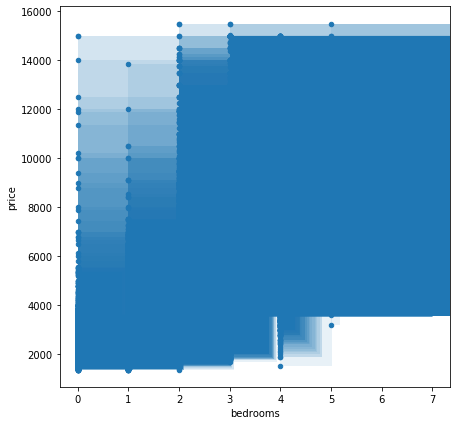

In [39]:
# Test function
feature = 'bedrooms'
squared_errors(train, feature, target, m=0, b=y_train.mean())

### What's the best test MAE you can get? Share your score and features used with your cohort on Slack!

Mean Squared Error: 15790606.103300983
Root Mean Squared Root: 3973.7395615844002
Mean Absolute Error: 3563.096485442382
R^2: -4.084938433063717


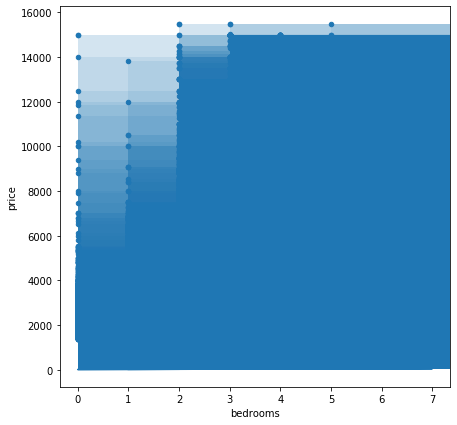

In [42]:
squared_errors(train, feature, target, m=5, b=5)